
# Montar Google Drive

Conecta mi Drive al entorno de Colab para poder acceder a archivos almacenados.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



# Instalación de dependencias y descarga de modelos

Instala librerías necesarias (PyTorch, OpenCV, Segment Anything, Transformers)
Clona el repositorio SegmentAnything3D, crea carpeta de los checkpoints y descarga el modelo SAM.

In [ ]:
!pip install -q torch torchvision torchaudio
!pip install -q opencv-python matplotlib tqdm imageio
!pip install -q git+https://github.com/facebookresearch/segment-anything.git
!pip install -q transformers accelerate pillow

!git clone https://github.com/Pointcept/SegmentAnything3D.git
%cd SegmentAnything3D
!mkdir checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth -O checkpoints/sam_vit_b.pth
print('Modelos descargados')

# Extracción de frames del video
Tomando como base el video, toma un máximo de 8 frames, los redimensiona a 640x360 y los guarda en una carpeta local.

In [ ]:
import cv2
import os

video_path = '/content/drive/MyDrive/pallet_counting_project/data/raw_videos/DJI_20251227113309_0010_D - SAM3D Test.mp4'
frames_dir = '/content/sam3d_frames'
os.makedirs(frames_dir, exist_ok=True)

cap = cv2.VideoCapture(video_path)
max_frames = 8
count = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame_small = cv2.resize(frame, (640, 360))
    save_path = f'{frames_dir}/frame_{count:03d}.jpg'
    cv2.imwrite(save_path, frame_small)
    count += 1
    if count >= max_frames:
        break

cap.release()
print('Frames guardados:', count)

Frames guardados: 8


# Cargar modelos SAM y DINO

Configura SAM para segmentación y DINO para detección de objetos sin supervisión, y los coloca en GPU si está disponible.

In [ ]:
import torch
import sys
from segment_anything import sam_model_registry, SamPredictor
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# SAM
checkpoint_path = '/content/SegmentAnything3D/checkpoints/sam_vit_b.pth'
sam = sam_model_registry['vit_b'](checkpoint=checkpoint_path)
sam.to(device)
predictor = SamPredictor(sam)

# DINO
dino_model_id = 'IDEA-Research/grounding-dino-base'
processor = AutoProcessor.from_pretrained(dino_model_id)
dino_model = AutoModelForZeroShotObjectDetection.from_pretrained(dino_model_id).to(device)

print('Modelos cargados en:', device)

# Detección de cajas con DINO

Define una función para detectar cajas en una imagen usando DINO basado en un texto descriptivo de cajas.

In [ ]:
import numpy as np
from PIL import Image

TEXT_PROMPT = "a cardboard box. a carton box. stacked boxes. shipping box. warehouse cardboard boxes"
BOX_THRESHOLD = 0.15
TEXT_THRESHOLD = 0.30

def dino_detect_boxes(image_rgb):
    pil_img = Image.fromarray(image_rgb)
    inputs = processor(images=pil_img, text=TEXT_PROMPT, return_tensors='pt').to(device)

    with torch.no_grad():
        outputs = dino_model(**inputs)

    target_sizes = torch.tensor([pil_img.size[::-1]]).to(device)

    results = processor.post_process_grounded_object_detection(
        outputs,
        inputs.input_ids,
        target_sizes=target_sizes,
        box_threshold=BOX_THRESHOLD,
        text_threshold=TEXT_THRESHOLD
    )[0]

    boxes = results['boxes'].detach().cpu().numpy() if len(results['boxes']) else np.empty((0,4))
    scores = results['scores'].detach().cpu().numpy() if len(results['scores']) else np.array([])
    labels = results['labels']
    return boxes, scores, labels

# SAM guiado por DINO
Modifica la función anterior para que SAM use las cajas detectadas por DINO, convirtiendo coordenadas normalizadas a píxeles.

In [ ]:
def dino_detect_boxes(image_rgb):

    pil_img = Image.fromarray(image_rgb)

    inputs = processor(
        images=pil_img,
        text=TEXT_PROMPT,
        return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        outputs = dino_model(**inputs)

    # logits de clasificación
    logits = outputs.logits.sigmoid()[0]      # (num_queries, num_tokens)
    boxes = outputs.pred_boxes[0]             # (num_queries, 4)

    # Obtener score máximo por query
    scores, _ = logits.max(dim=1)

    # Filtrar por threshold
    keep = scores > BOX_THRESHOLD

    boxes = boxes[keep]
    scores = scores[keep]

    if boxes.shape[0] == 0:
        return np.empty((0,4)), np.array([]), []

    # Convertir cajas de formato normalizado a píxeles
    h, w = image_rgb.shape[:2]
    boxes_xyxy = boxes.clone()

    boxes_xyxy[:, 0] = boxes[:, 0] - boxes[:, 2] / 2
    boxes_xyxy[:, 1] = boxes[:, 1] - boxes[:, 3] / 2
    boxes_xyxy[:, 2] = boxes[:, 0] + boxes[:, 2] / 2
    boxes_xyxy[:, 3] = boxes[:, 1] + boxes[:, 3] / 2

    boxes_xyxy[:, [0,2]] *= w
    boxes_xyxy[:, [1,3]] *= h

    boxes_xyxy = boxes_xyxy.cpu().numpy()
    scores = scores.cpu().numpy()

    return boxes_xyxy, scores, ["box"] * len(scores)

# Procesar todos los frames

Itera sobre todos los frames extraídos, aplica detección SAM+DINO, guarda resultados y calcula conteo de objetos por frame.

In [ ]:
import glob

frame_paths = sorted(glob.glob(frames_dir + '/*.jpg'))
conteos_por_frame = []
resultados = []

for fp in frame_paths:
    img_bgr = cv2.imread(fp)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    semantic_masks, dino_boxes, dino_scores, dino_labels = sam_dino_boxes_for_frame(img_rgb)

    conteos_por_frame.append(len(semantic_masks))
    resultados.append((fp, img_rgb, semantic_masks, dino_boxes, dino_scores, dino_labels))

print('Conteo por frame:')
for fp, c in zip(frame_paths, conteos_por_frame):
    print(os.path.basename(fp), '->', c)

print('Promedio:', round(float(np.mean(conteos_por_frame)), 2))

Conteo por frame:
frame_000.jpg -> 88
frame_001.jpg -> 89
frame_002.jpg -> 86
frame_003.jpg -> 90
frame_004.jpg -> 96
frame_005.jpg -> 90
frame_006.jpg -> 93
frame_007.jpg -> 93
Promedio: 90.62



# Visualización Final

Muestra un frame con máscaras semánticas superpuestas, contornos y etiquetas numeradas.

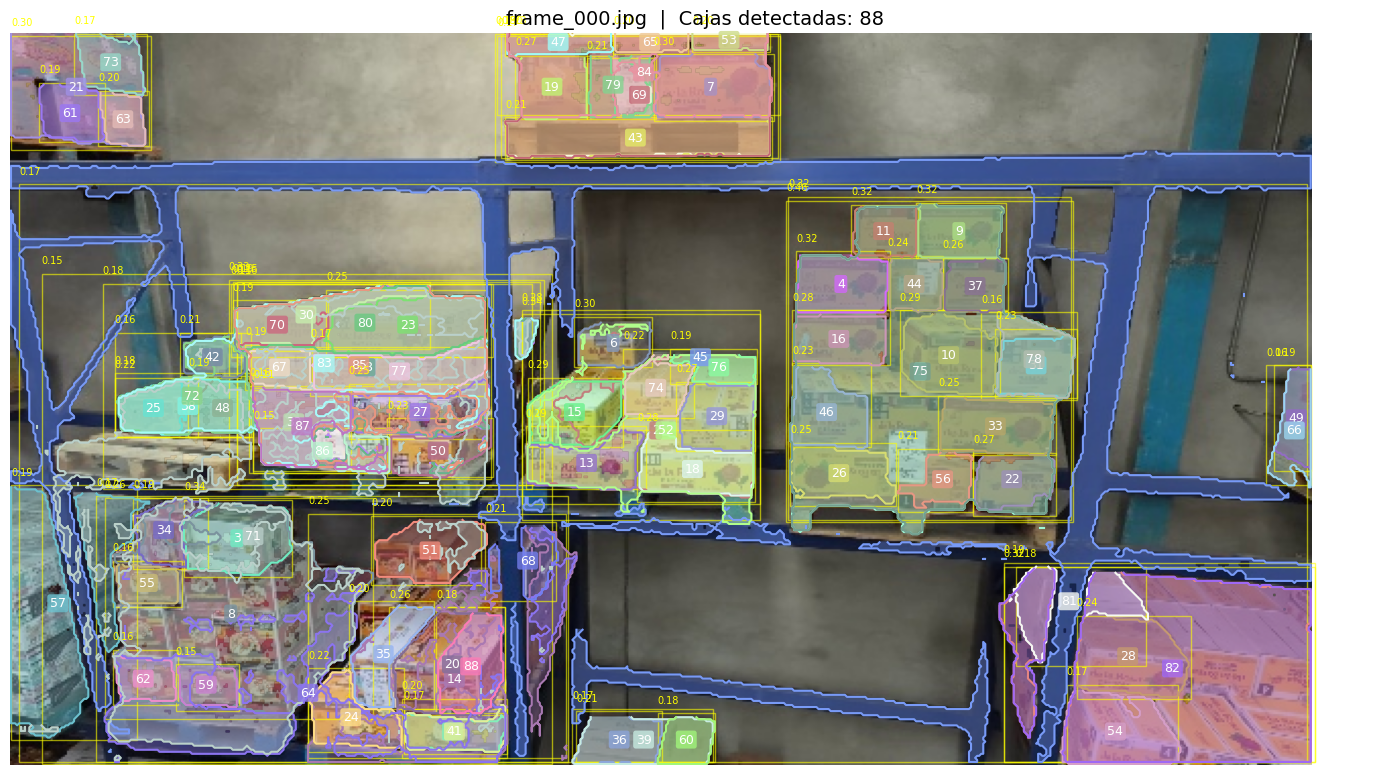

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import os

fp, img_rgb, semantic_masks, dino_boxes, dino_scores, dino_labels = resultados[0]

image = img_rgb.copy()
h, w = image.shape[:2]

fig, ax = plt.subplots(1, figsize=(14,8))
ax.imshow(image)

# Colores suaves
np.random.seed(42)

def random_soft_color():
    color = np.random.rand(3)
    color = 0.6 * color + 0.4  # Uso de tonos mas suaves
    return color

for i, mask in enumerate(semantic_masks):

    color = random_soft_color()
    m = mask.astype(bool)

    # Crear overlay RGBA
    overlay = np.zeros((h, w, 4))
    overlay[m] = [color[0], color[1], color[2], 0.35]  # alpha tenue

    ax.imshow(overlay)

    # Contorno fino
    contours, _ = cv2.findContours(
        mask.astype(np.uint8),
        cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE
    )

    for cnt in contours:
        cnt = cnt.squeeze()
        if len(cnt.shape) == 2:
            ax.plot(cnt[:,0], cnt[:,1], color=color, linewidth=1.5)

    # ID pequeño centrado
    y, x = np.where(m)
    if len(x) > 0:
        cx, cy = int(np.mean(x)), int(np.mean(y))
        ax.text(
            cx,
            cy,
            str(i+1),
            color="white",
            fontsize=9,
            ha="center",
            va="center",
            bbox=dict(
                facecolor=color,
                edgecolor="none",
                boxstyle="round,pad=0.2",
                alpha=0.8
            )
        )

# Bounding boxes DINO
for j, box in enumerate(dino_boxes):
    x1, y1, x2, y2 = box.astype(int)
    score = dino_scores[j] if j < len(dino_scores) else 0

    rect = patches.Rectangle(
        (x1, y1),
        x2 - x1,
        y2 - y1,
        linewidth=1,
        edgecolor='yellow',
        facecolor='none',
        alpha=0.6
    )
    ax.add_patch(rect)

    ax.text(
        x1,
        y1 - 4,
        f"{score:.2f}",
        fontsize=7,
        color="yellow",
        verticalalignment='bottom'
    )

ax.set_title(
    f"{os.path.basename(fp)}  |  Cajas detectadas: {len(semantic_masks)}",
    fontsize=14
)

ax.axis("off")
plt.tight_layout()
plt.show()